In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import copy
import matplotlib
%matplotlib inline
sys.path.append("..")
from demo_2_awac import och_2_awac
import adept_envs
import gym
env = gym.make("franka_knob_cabinet_slider_resetfree_newcode-v1")

# all_paths = ['../../../sim_franka/rpl_reset_free/recordings/play_segmented_CS.pkl',]
             
all_paths = ['/usr/local/google/home/abhishekunique/hardware_franka/rpl_reset_free/recordings/recording_3elems_knob.pkl']
dat = []

for p in all_paths:
    dat_curr = pickle.load(open(p, 'rb'))
    dat += dat_curr
print(len(dat))


234


(200, 18)


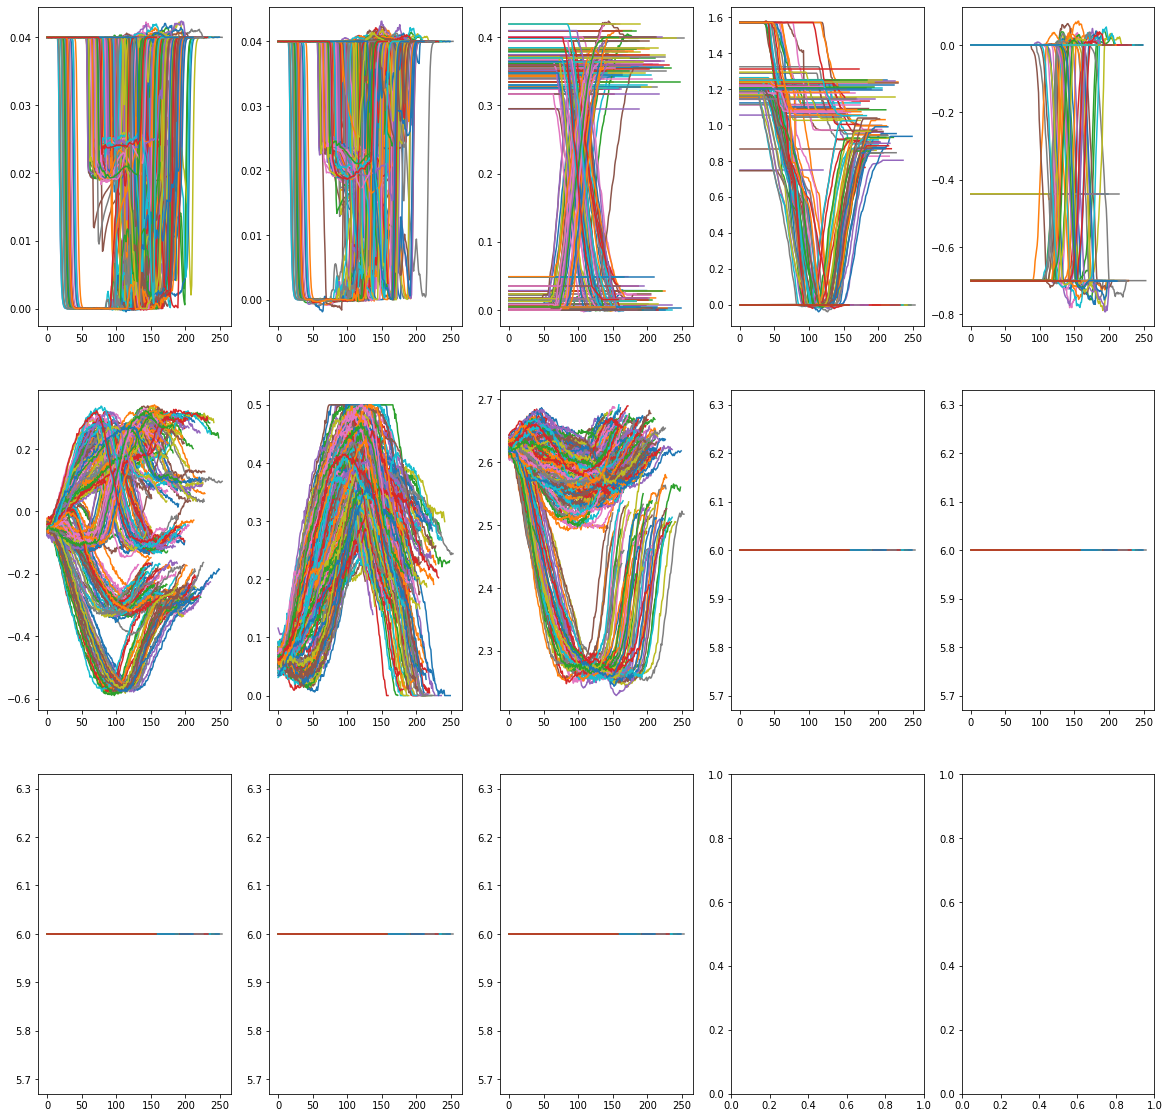

In [2]:
list_awac = och_2_awac(dat)
print(list_awac[0]['observations'].shape)
curr_x = 0
fig, ax = plt.subplots(3, 5, figsize=(20, 20))
for p in list_awac:
    for i in range(3):  
        for j in range(5):
            if i*5 + j == 13:
                break
            if i*5 +j == 1: 
                ax[i][j].plot(range(curr_x, curr_x + len(p['observations'])), p['observations'][:, i*5 + j])
            else:
                ax[i][j].plot(range(curr_x, curr_x + len(p['observations'])), p['observations'][:, i*5 + j])

plt.show()

BROKEN
BROKEN
BROKEN
(223, 18)
(161, 18)
(162, 18)
(208, 18)
(217, 18)
(185, 18)
(177, 18)
(175, 18)
(153, 18)
(168, 18)
(208, 18)
(202, 18)
(130, 18)
(169, 18)
(133, 18)
(161, 18)
(189, 18)
(161, 18)
(207, 18)
(179, 18)
(236, 18)
(199, 18)
(237, 18)
(147, 18)
(163, 18)
(228, 18)
(174, 18)
(188, 18)
(138, 18)
(151, 18)
(249, 18)
(194, 18)
(208, 18)
(187, 18)
(187, 18)
(254, 18)
(242, 18)
(188, 18)
(250, 18)
(229, 18)
(212, 18)
(151, 18)
(222, 18)
(214, 18)
(206, 18)
(170, 18)
(226, 18)
(164, 18)
(194, 18)
(197, 18)
(150, 18)
(203, 18)
(196, 18)
(229, 18)
(174, 18)
(172, 18)
(190, 18)
(201, 18)
(214, 18)
(175, 18)
(183, 18)
(220, 18)
(225, 18)
(206, 18)
(185, 18)
(156, 18)
(148, 18)
(188, 18)
(224, 18)
(213, 18)
(139, 18)
(200, 18)
(204, 18)
(127, 18)
(175, 18)
(140, 18)
(161, 18)
(237, 18)
(227, 18)
(176, 18)
(144, 18)
(163, 18)
(205, 18)
(138, 18)
(208, 18)
(190, 18)
(175, 18)
(207, 18)
(164, 18)
(177, 18)
(129, 18)
(160, 18)
(163, 18)
(136, 18)
(161, 18)
(202, 18)
(216, 18)
(142, 18)

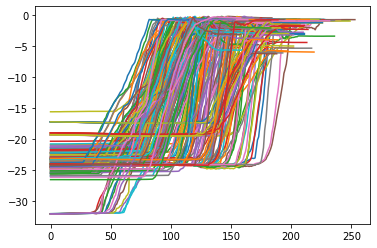

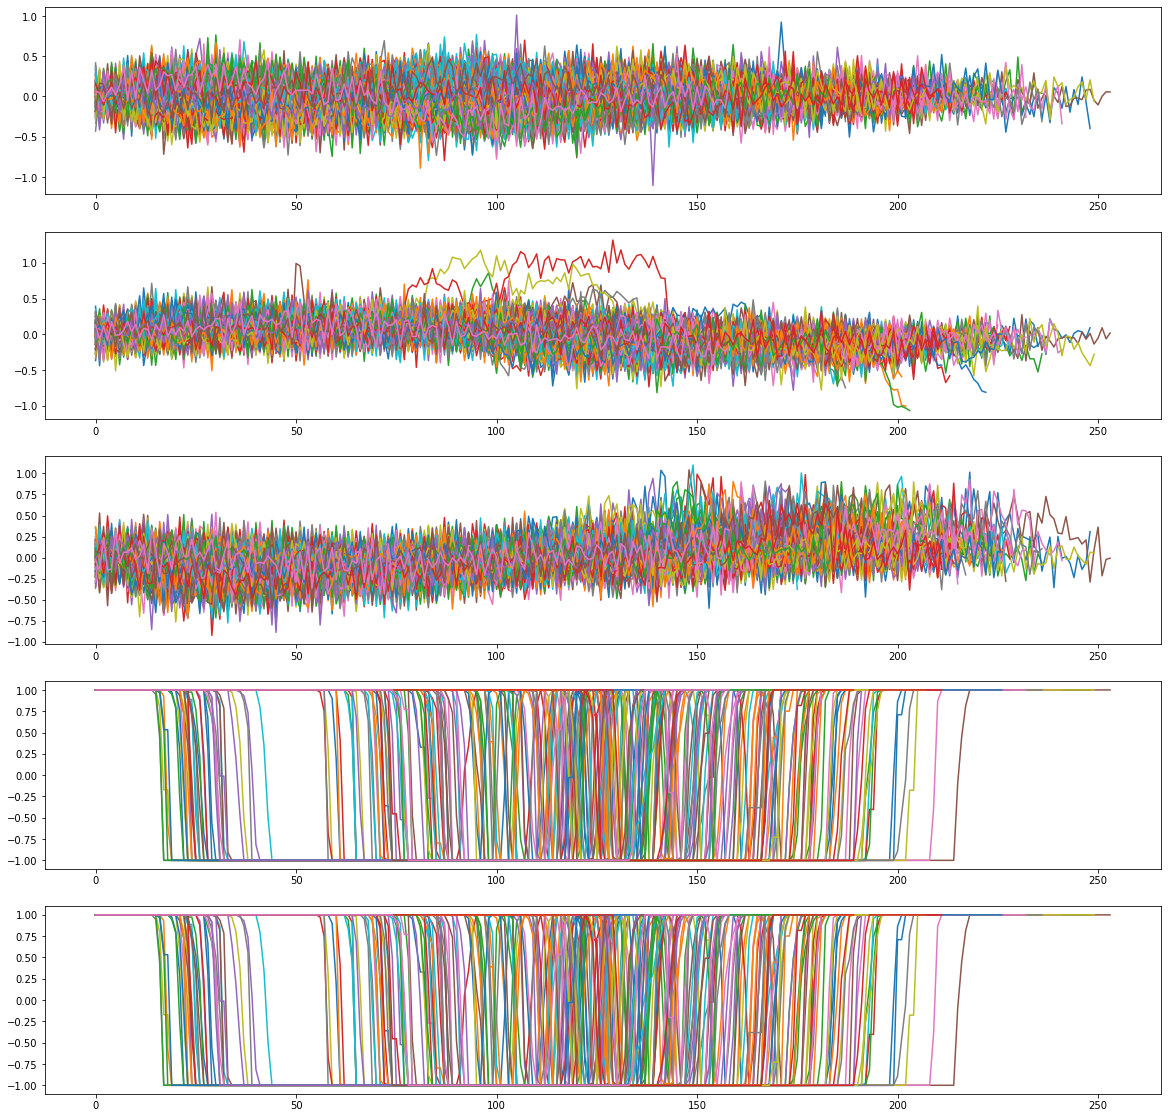

NUMBER OF FILTERED PATHS IS 227


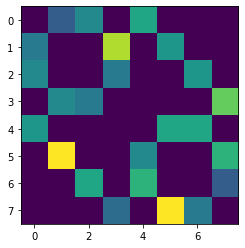

In [4]:
import itertools
def check_goal_completion(curr_pos):
    max_objs = np.array([0.27, 0.7, -0.1])
    min_objs = np.array([0.07, 0.1, -0.6])
    init_bitflips = np.array([0, 0, 0])
    curr_bitflips = init_bitflips.copy()
    broken = False
    for j, pos_idx in enumerate([0, 1, 2]):
        if curr_pos[pos_idx] > max_objs[j]:
            curr_bitflips[j] = 1
        elif curr_pos[pos_idx] < min_objs[j]:
            curr_bitflips[j] = 0
        else:
            print("BROKEN")
            broken = True
    new_idx = 4*curr_bitflips[0] + 2*curr_bitflips[1] + curr_bitflips[2]
    return new_idx, broken

idx_completion = False
def end_relabel(env, path):
    o_size = 8
#     path['observations'][:, o_size:] = path['observations'][-1, :o_size].copy()
#     path['next_observations'][:, o_size:] = path['observations'][-1, :o_size]
    env.env._goal_idx, _ = check_goal_completion(path['observations'][-1, 2:5])
    env.env._current_idx, _ = check_goal_completion(path['observations'][0, 2:5])
    concat_val = np.ones((path['observations'].shape[0], 10))*env.env._goal_idx
    path['observations'] = np.concatenate([path['observations'][:, :o_size], concat_val], axis=-1)
    path['next_observations'] = np.concatenate([path['next_observations'][:, :o_size], concat_val], axis=-1)
    env.env.goal = concat_val #path['observations'][-1, :o_size].copy()
    env.env._idx_completion = idx_completion
    path['rewards'] = np.zeros_like(path['rewards'])
    for idx in range(len(path['observations'])):
        reward_dict = env.env.get_reward_dict(None, {'obj_qp': path['observations'][idx:idx+1, 2:5],
                                                     'mocap_pos': path['observations'][idx:idx+1, 5:8]})
        path['rewards'][idx] = np.sum([v for k, v in reward_dict.items()])
    return path


list_awac = och_2_awac(dat)
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt 
curr_x = 0  
label_list = itertools.product(['SC', 'SO'], ['CC', 'CO'], ['MC', 'MO'],)
tasks = ['-'.join(s) for s in label_list]
# tasks = ['CC', 'CO', 'OC', 'OO']
task_list = []
adjacency_matrix = np.zeros((8, 8))
labeled_goals = [[] for _ in range(8)]
counts_starts = np.zeros(8)
counts_goals = np.zeros(8)
end_states_val = [None for _ in range(8)]
end_states = [None for _ in range(8)]

path_lists = [[[] for _ in range(8)] for _ in range(8)]

filtered_paths = []
for i, path in enumerate(list_awac):
    si, b = check_goal_completion(path['observations'][0, 2:5])
    gi, b2 = check_goal_completion(path['observations'][-1, 2:5])
    if b or b2:
        continue
    end_relabel(env, path)
    print(path['observations'].shape)
    plt.plot(path['rewards'])
    filtered_paths.append(path)
plt.show()
    
for path in filtered_paths:
    mocap_poss = np.concatenate([path['actions'][:, :3], path['actions'][:, -2:]], axis=-1)
    path['actions'] = mocap_poss
fig,  ax = plt.subplots(5, figsize=(20, 20))
for p in filtered_paths:
    for i in range(5):  
        ax[i].plot(p['actions'][:, i])
plt.show()

print("NUMBER OF FILTERED PATHS IS %d"%(len(filtered_paths)))


for p in filtered_paths:
    curr_x += len(p['observations'])
    start_idx, _ = check_goal_completion(p['observations'][0, 2:5])
    start = tasks[start_idx]
    end_idx, _ = check_goal_completion(p['observations'][-1, 2:5])
    end = tasks[end_idx]
    adjacency_matrix[start_idx, end_idx] += 1
    path_lists[start_idx][end_idx].append(copy.deepcopy(p))
    task_list.append(check_goal_completion(p['observations'][-1, 2:5])[0])
    labeled_goals[end_idx].append(p['observations'][-1])
    counts_goals[end_idx] += 1
    counts_starts[start_idx] += 1
    if end_states_val[end_idx] is None:
        end_states_val[end_idx] = p['observations'][-1, :8]
        end_states[end_idx] = np.ones(10)*end_idx
plt.show() 

plt.imshow(adjacency_matrix)
plt.show()

In [ ]:
pickle.dump(end_states_val, open('3element_knob_goal_vals.pkl', 'wb'))
pickle.dump(end_states, open('3element_knob_goal_idxs.pkl', 'wb'))

In [5]:
pickle.dump(filtered_paths, open('demo_list_3elements_KNOBCABINETSLIDER_deltapos_noredundancy_smallernoise_rewardfixed_newcode.pkl', 'wb'))

In [8]:
pickle.dump(path_lists[0][4], open('3elems_path_04_knob.pkl', 'wb'))

In [13]:
path_lists[1][3][0]['observations'][:, 8:]

array([[3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       ...,
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.]])